# Post Processing Notebook

Let's use this notebook to organise and run our post-processing of the data.

In [25]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import rebound

%config InlineBackend.figure_format = 'retina'

In [26]:
# Simulations Folder
folder = '../data/simulations/2018-11-21_21-09-52/'

In [27]:
sims = rebound.SimulationArchive(os.path.join(folder, 'sim_archive.bin'))
planets = pd.read_csv(os.path.join(folder, 'init', 'planets.csv'))
num_planets = len(planets)
post_folder = os.path.join(folder, 'post')

## Sort the Units

In [106]:
M_DIM = 1.989e30 # kg
T_DIM = 1 / (2*np.pi) # years
D_DIM = 1.496e11 # m

M_DIM, T_DIM, D_DIM

(1.989e+30, 0.15915494309189535, 149600000000.0)

In [107]:
t = np.array([s.t for s in sims]) * T_DIM

## Density of Test Particles
We work out the radial density and radial counts. 

In [28]:
dr = 0.1

In [29]:
particles = sims[-1].particles
coords = pd.DataFrame(np.array([[p.hash.value, p.x, p.y, p.z] for p in particles]), columns=['id', 'x', 'y', 'z'])

coords['r'] = np.sqrt(coords.x**2 + coords.y**2)

r = np.linspace(dr, np.ceil(max(coords.r)), np.ceil(max(coords.r)) / dr)
radial_count = np.zeros_like(r)
for i, r_i in enumerate(r):
    radial_count[i] = len(coords.r[(coords.r > r_i) & (coords.r < r_i + dr)])
    
df_rad_density = pd.DataFrame({'r': r, 'radial_count': radial_count, 'radial_density': radial_count/(2*np.pi*r)})

/home/alexk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


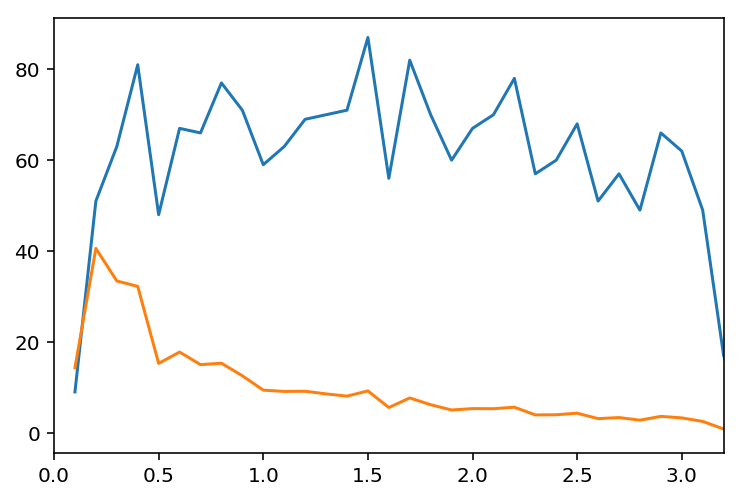

In [30]:
plt.plot(df_rad_density.r, df_rad_density.radial_count)
plt.plot(df_rad_density.r, df_rad_density.radial_density)
plt.xlim([0, 3.2])
plt.show()

## Particle Positions

In [35]:
particles = sims[-1].particles
parts = pd.DataFrame(np.array([[p.hash.value, p.x, p.y, p.z] for p in particles]), columns=['id', 'x', 'y', 'z'])

In [36]:
idx = (np.abs(parts.x) < 4) & (np.abs(parts.y) < 4)

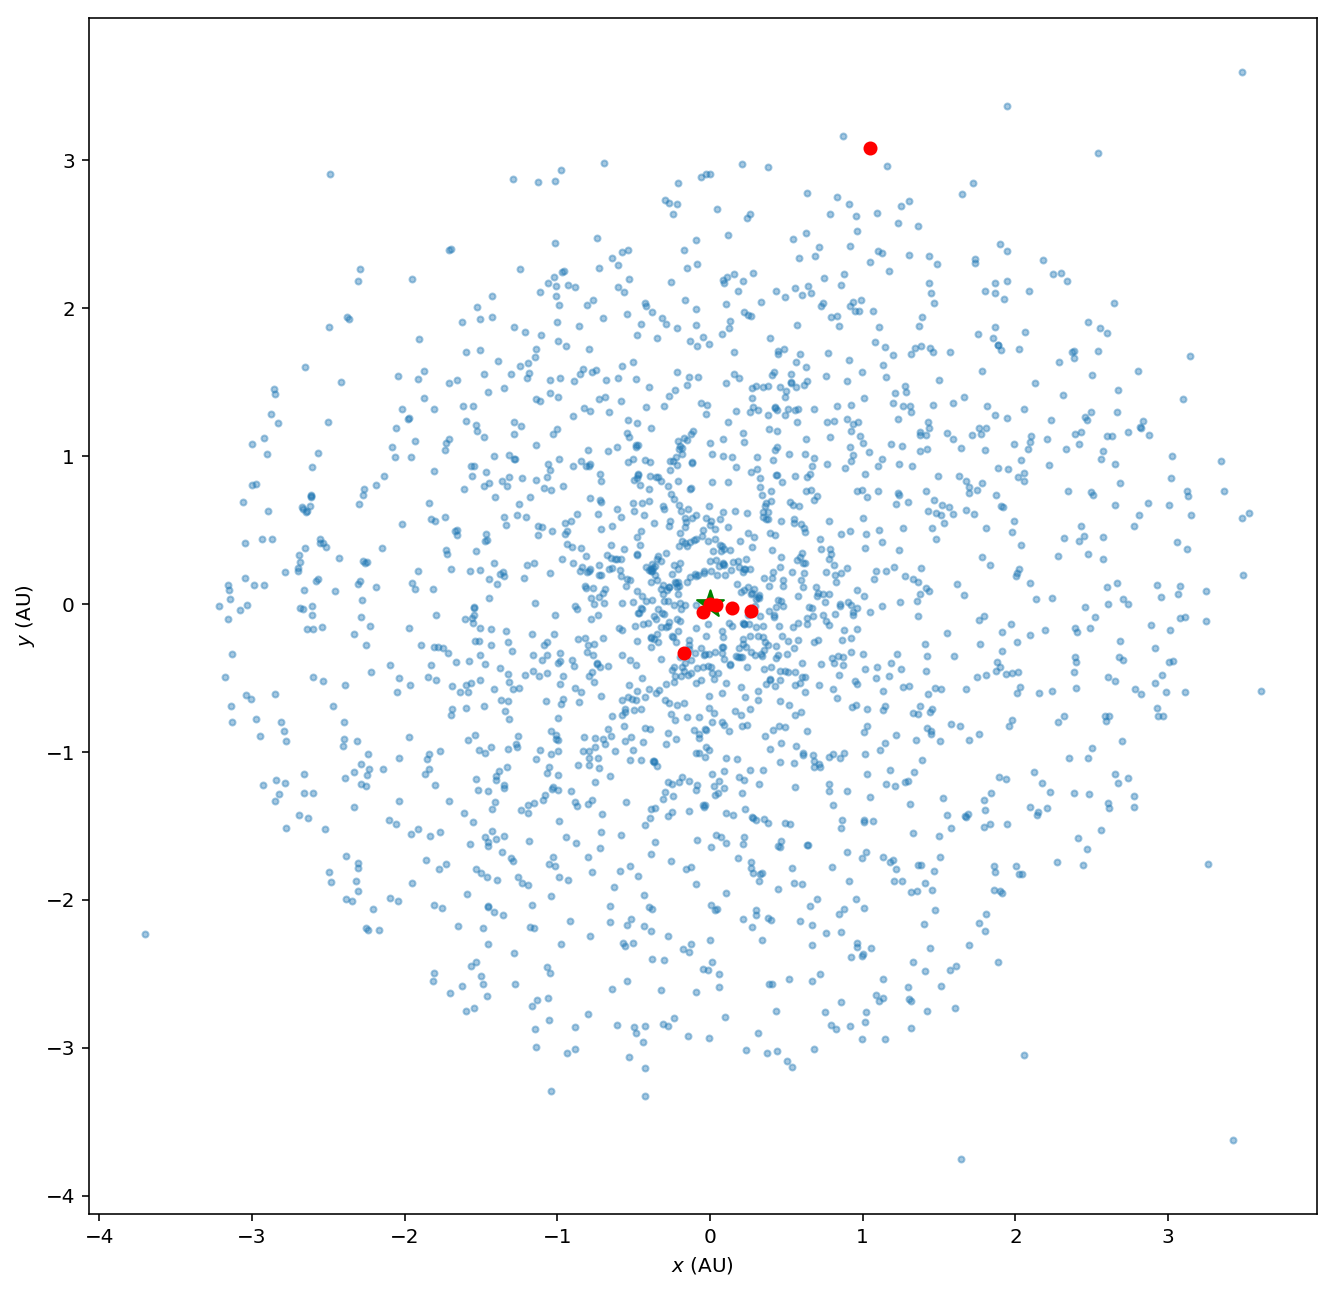

In [39]:
plt.figure(figsize=(11, 11))
plt.plot(parts.x[idx], parts.y[idx], '.', alpha=0.4)
plt.plot(parts.x[:7], parts.y[:7], 'or')
plt.scatter(0, 0, s=200, marker='*', c='green')
# plt.title('Position of Test Particles at $t = 1000$ Days')
plt.xlabel('$x$ (AU)')
plt.ylabel('$y$ (AU)')
plt.show()

## Orbital Elements
 - Inclination
 - Semi-Major Axis
 - Eccentricity

In [41]:
orbits = sims[-1].calculate_orbits()

In [124]:
elements = pd.DataFrame([(p.a, p.e, p.inc) for p in orbits[num_planets:]], columns=('a', 'e', 'inc'))

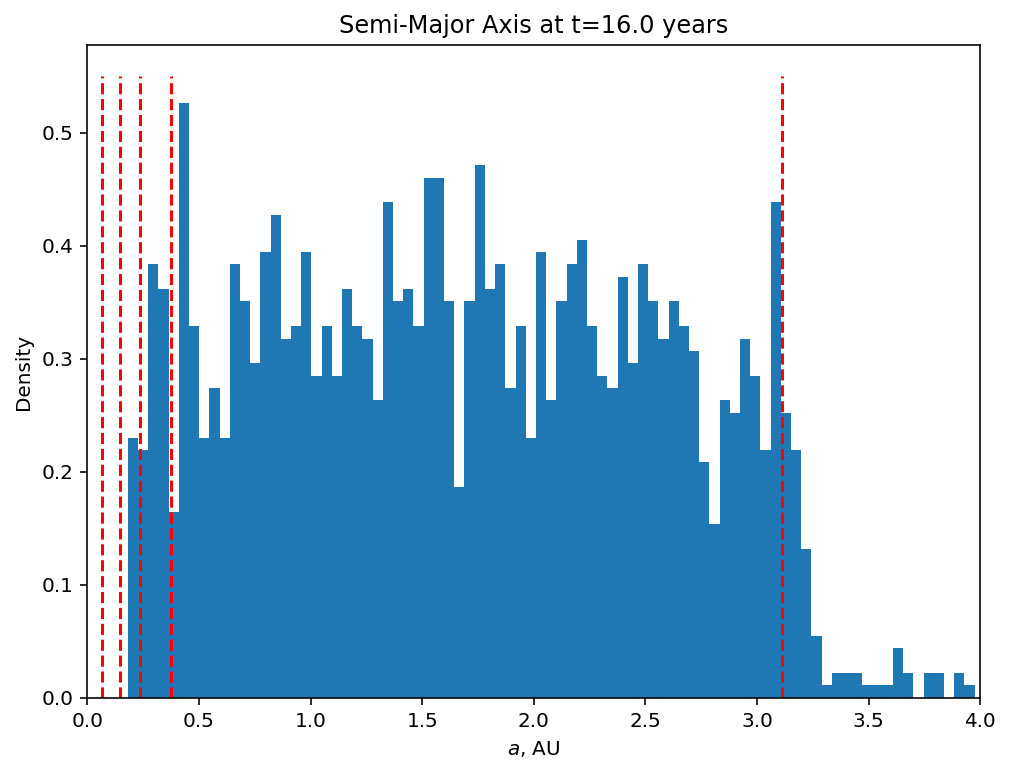

In [144]:
plt.figure(figsize=(8,6))
plt.title('Semi-Major Axis at t={} years'.format(round(t[-1])))
plt.xlabel('$a$, AU')
plt.ylabel('Density')
plt.xlim([0,4])

for i, p in enumerate(orbits[1:num_planets]):
    plt.plot([p.a, p.a], [0, 0.55], 'r--', label='Planet {}'.format(planets.pl_letter[i]))

plt.hist(elements.a[elements.a > 0], bins=100, density=True)
plt.show()

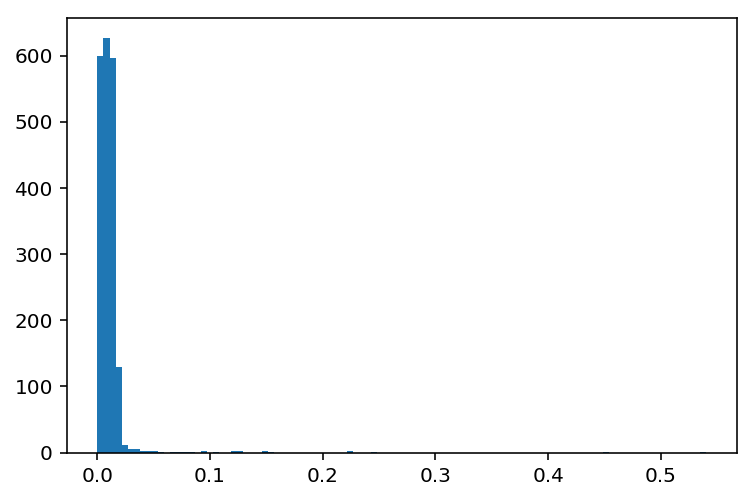

In [127]:
plt.hist(elements.inc, bins=100)
plt.show()

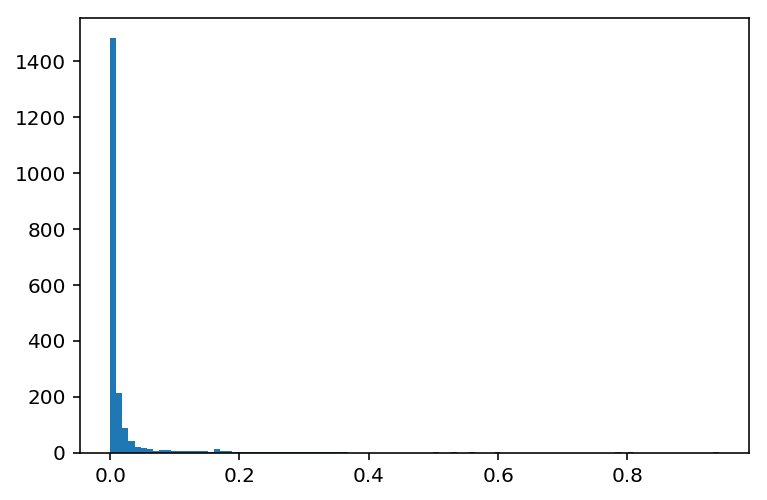

In [128]:
plt.hist(elements.e[elements.e < 1.1], bins=100)
plt.show()

## Conserved Quantities

In [108]:
energy = np.array([s.calculate_energy() for s in sims])
ang_mom = np.sqrt(np.sum(np.array([s.calculate_angular_momentum() for s in sims]) ** 2, axis=1))

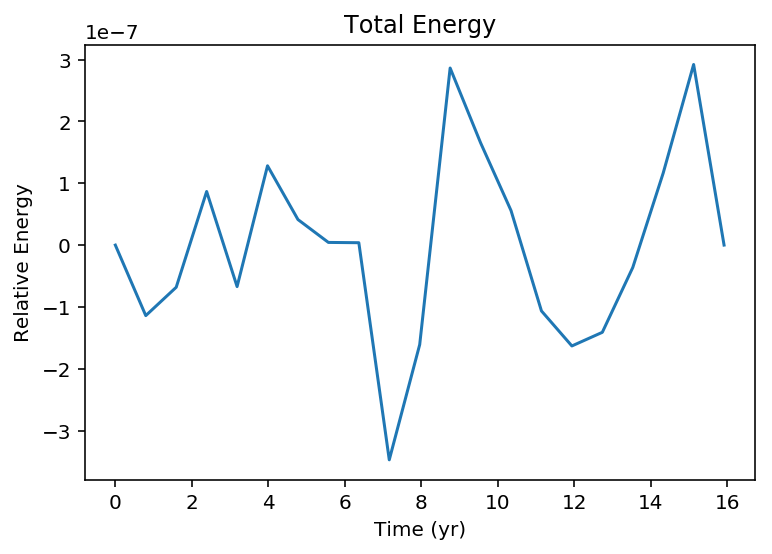

In [117]:
plt.plot(t, energy / energy[0] - 1)
plt.title('Total Energy')
plt.xlabel('Time (yr)')
plt.ylabel('Relative Energy')
plt.show()

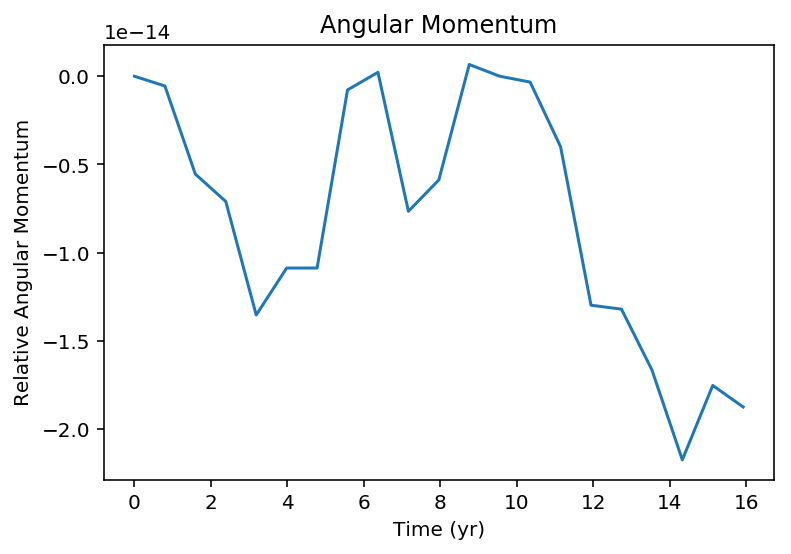

In [118]:
plt.plot(t, ang_mom / ang_mom[0] - 1)
plt.title('Angular Momentum')
plt.xlabel('Time (yr)')
plt.ylabel('Relative Angular Momentum')
plt.show()